<a href="https://colab.research.google.com/github/jpe17/DeepRANSProject/blob/main/DeepRANS_JoaoEsteves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DeepRANS**: A deep learning approach to solve turbulent flow.
**Description**: A project solving the RANS equation for 1D channel flow using neural networks, for different closure models. \\
**Methodology**: Uses the *NeuroDiffEq* library, applying it to the RANS by implementing a mixed boundary value problem. \\
**Closure models**: Prandtl mixing length, Van Driest mixing length, Rui FCNN and Ocariz CNN.

### **1st Step**: Set-up working space with Google drive
1.1. Import *DeepRANSProject_JoaoEsteves*.zip folder to personal Google Drive \
1.2. Mount Google Drive to Google Colab and unzip folder (only once)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!unzip /content/gdrive/MyDrive/DeepRANSProject.zip -d /content/gdrive/MyDrive/    # Unzip folder in google drive - Only execute this once

Archive:  /content/gdrive/MyDrive/DeepRANSProject.zip
   creating: /content/gdrive/MyDrive/DeepRANSProject/
   creating: /content/gdrive/MyDrive/DeepRANSProject/DeepRANS/
   creating: /content/gdrive/MyDrive/DeepRANSProject/DeepRANS/data/
  inflating: /content/gdrive/MyDrive/DeepRANSProject/DeepRANS/data/chan590.txt  
  inflating: /content/gdrive/MyDrive/DeepRANSProject/DeepRANS/data/JHTDB_half_channel_128X512X96_25frames.txt  
  inflating: /content/gdrive/MyDrive/DeepRANSProject/DeepRANS/data/JHTDB_half_channel_128X512X96_25frames_cg.txt  
  inflating: /content/gdrive/MyDrive/DeepRANSProject/DeepRANS/data/JHTDB_half_channel_128X512X96_40frames.txt  
  inflating: /content/gdrive/MyDrive/DeepRANSProject/DeepRANS/data/JHTDB_half_channel_128X512X96_40frames_cg.txt  
  inflating: /content/gdrive/MyDrive/DeepRANSProject/DeepRANS/data/kEpsilon_LM_Channel_Retau1000.txt  
  inflating: /content/gdrive/MyDrive/DeepRANSProject/DeepRANS/data/kEpsilon_LM_Channel_Retau180.txt  
  inflating: /content

### **2nd Step**: Importing required libraries
2.1. Import libraries from Python. Might need to $pip install them first into the environment.\
2.2. Import libraries from *NeuroDiffEq* - for solving differential equations.\
2.3. Import libraries from *DeepRANS* - with DNS simulation data sorting and closure models.

In [3]:
'''Importing General Python and Pytorch Libraries''' 
import numpy as np
from numpy import genfromtxt
import pandas as pd
import warnings
import os
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from itertools import chain
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [4]:
'''Importing NeuroDiffEq library'''                                               # This folder should be uploaded regularly to Google Drive with the most recent updates.
os.chdir(r'/content/gdrive/MyDrive/DeepRANSProject/neurodiffeq')                  # Change to Neurodiffeq solver
from neurodiffeq.neurodiffeq import diff                                          # Import automatic differentiation operator
from neurodiffeq.generators import Generator1D                                    # Import generator to define points at which NN is trained
from neurodiffeq.solvers import Solver1D, Adam                                    # Import NN ODE solver and Adam optimizer
from neurodiffeq.conditions import DoubleEndedBVP1D, IVP                             # Import boundary conditions
from neurodiffeq.networks import FCNN, Swish, SinActv                             # Import neural network FCNN architecture and activation functions: Swish and SinActv

In [32]:
'''From RANS Scripts'''
os.chdir(r'/content/gdrive/MyDrive/DeepRANSProject/DeepRANS/models')
from closure_model import a_uv_from_Prandtl, a_uv_from_vanDriest                  # Import mixing length closure models: Assessing a_uv and its derivative
from closure_model import a_uv_from_Rui, a_uv_from_Ocariz                         # Import data-driven closure models: Assessing a_uv and its derivative       
from models import NetworkStructure, MLP_BC_Re, CONV_NN_BC                        # Import data-driven closure models architectures
from utils_train import ModelTrainer, calc_r2, plot_loss_history                  # Import ModelTrained, R2 score, Loss history
from utils_preprocess import make_dataframe, channel_parameters                   # Import preprocessing utils: Preprocessing of raw DNS data and channel parameters for DNS simulations
from numerical_ODE_solver import solve_ODE                                        # Import numerical ODE solver: only works for mixing length models

### **3rd Step**: Defining variables, hyperparameters and others
3.1. Choose Reynolds number \\
3.2. Choose Neural Network hyperparameters \\
3.3. Choose Closure Model for RANS

In [7]:
# Reynolds number
Retau = 1000                                                                     # From 180, 550, 1000, 2000 and 5200           
 
# Parameters for Neural Network
epochs = 100                                                                      # Number of epochs for training
hidden = [20,20,20]                                                               # Architecture of NeuroDiffEq: Column = hidden layer & Value = number of neurons
learning_rate = 1e-6                                                              # Initial learning rate
stp_size = 1000                                                                   # Learning rate scheduler - Step size: decreases after x iterations
rate_decay = 0.5                                                                  # Learning rate scheduler - Rate of decay: next_lr = previous_lr x rate_decay
optimizer_type = 'Adam'                                                           # Optimizer type - Usually 'Adam' or 'SGD'                          
activation = Swish                                                                # Activation function - Usually nn.Tanh, Swish or SinActv
points_trainer = 5000                                                             # Number of points used when solving the differential equation
distribution = 'equally-spaced'                                                   # Distribution of points - 'Equally-spaced' or 'log-spaced'
batch_train = 1                                                                   # Number of training batches
batch_valid = 0                                                                   # Number of validation batches
 
# Closure model
model = 'Rui'                                                                     # Closure model - From 'Prantl', 'vanDriest', 'Rui' or 'Ocariz'
 
# Starting stage
ss = 1500000                                                                      # Choose stage at which training starts - either 0 or 1500000 iterations
 
# Parameters for Channel flow
Re_tau, u_tau, nu = channel_parameters(Retau)                                     # Channel parameters of interest - Exact
delta = 1                                                                         # Non-dimensionalized half-width
y_min = 0                                                                         # Wall non-dimensionalized position
y_max = delta                                                                     # Half-width non-dimensionalized position
k = 0.384                                                                         # Van Karman constant - from DNS
A_plus = 26                                                                       # Van Driest damping - from Pope book
C = delta*u_tau/(A_plus*nu)                                                       # Parameter of interest
 
# Define RANS boundary conditions - Dirichlet Neumann
boundary = DoubleEndedBVP1D(x_min=y_min,x_max=y_max,x_min_val=0,x_max_prime=0)    # No-slip condition and Symmetry

### **4th Step**: Import pre-trained closure models and assess if correct
4.1. Import pre-trained Rui closure model (MLP_Re_BC) \\
4.2. Import pre-trained Ocariz closure model (CNN) \\
4.3. Import DNS data \\
4.4. Test Rui closure model with DNS du/dy and y \\
4.5. Test Ocariz closure model with DNS du/dy and y \\
4.6. Compare DNS, Rui and Ocariz a_uv results

In [8]:
'''Import Data-Driven Closure Models'''
# Rui's Model
rui_model = torch.load('model_Rui_FCNN.pt')
rui_model = rui_model.to(torch.float64)
rui_model = rui_model.cuda()
 
#Ocariz's Model
ocariz_model = torch.load('model_Ocariz_CNN')
ocariz_model = ocariz_model.to(torch.float64)
ocariz_model = ocariz_model.cpu()

In [9]:
'''Import DNS Data'''
# Load DNS Data
df_dns = pd.concat([make_dataframe(Retau)])
 
#Finding relevant DNS results
y_norm_DNS = df_dns['y']/delta
u_norm_DNS = df_dns['u']/u_tau
du_dy_norm_DNS = df_dns['du_dy']*delta/u_tau
a_uv_norm_DNS = df_dns['a_uv']/(u_tau**2)

In [10]:
'''Assess if models are imported properly'''
# Obtain Anisotropic Reynolds Stress Tensor from DNS data
a_uv_norm_Prandtl_DNS = a_uv_from_Prandtl(du_dy_norm_DNS,y_norm_DNS,Retau,'a_uv','torch')
a_uv_norm_vanDriest_DNS = a_uv_from_vanDriest(du_dy_norm_DNS,y_norm_DNS,Retau,'a_uv','torch')
a_uv_norm_Rui_DNS = a_uv_from_Rui(du_dy_norm_DNS,y_norm_DNS,Retau,'a_uv','torch')
a_uv_norm_Ocariz_DNS = a_uv_from_Ocariz(du_dy_norm_DNS,y_norm_DNS,Retau,'a_uv','torch')

# Obtain derivative of Anisotropic Reynolds Stress Tensor from DNS data
da_uv_dy_norm_Prandtl_DNS = a_uv_from_Prandtl(du_dy_norm_DNS,y_norm_DNS,Retau,'der','torch')
da_uv_dy_norm_vanDriest_DNS = a_uv_from_vanDriest(du_dy_norm_DNS,y_norm_DNS,Retau,'der','torch')
da_uv_dy_norm_Rui_DNS = a_uv_from_Rui(du_dy_norm_DNS,y_norm_DNS,Retau,'der','torch')
da_uv_dy_norm_Ocariz_DNS = a_uv_from_Ocariz(du_dy_norm_DNS,y_norm_DNS,Retau,'der','torch')

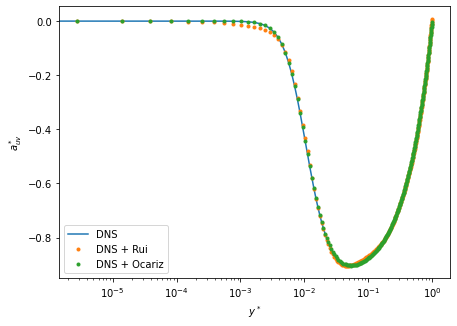

In [13]:
# Plot Comparison between a_uv from DNS, Rui FCNN and Ocariz CNN
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(y_norm_DNS,a_uv_norm_DNS, '-', label='DNS')
#ax.plot(y_norm_DNS,a_uv_norm_Prandtl_DNS.detach().cpu().numpy(), '.', label='DNS + Prandtl')
#ax.plot(y_norm_DNS,a_uv_norm_vanDriest_DNS.detach().cpu().numpy(), '.', label='DNS + Van Driest')
ax.plot(y_norm_DNS,a_uv_norm_Rui_DNS.detach().cpu().numpy(), '.', label='DNS + Rui')
ax.plot(y_norm_DNS,a_uv_norm_Ocariz_DNS.detach().cpu().numpy(), '.', label='DNS + Ocariz')
ax.set_ylabel(r'$a^*_{uv}$')
ax.set_xlabel(r'$y^*$')
ax.legend(loc='best')
ax.set_xscale('log')
plt.show()

The models are imported properly. Now let us see if the differentiating operator is working properly. We cannot take d_a_uv^\*/dy^\* from DNS, as reference.

We then compare the values of d_a_uv^\*/dy^\*.

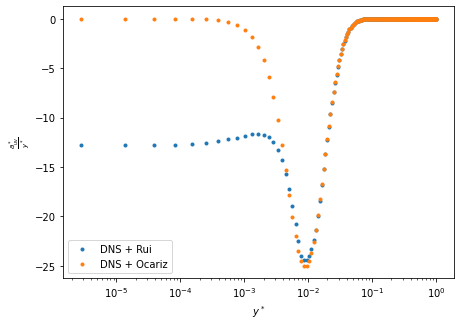

In [18]:
# Plot Comparison between a_uv from DNS, Rui FCNN and Ocariz CNN
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
#ax.plot(y_norm_DNS,da_uv_dy_norm_Prandtl_DNS.detach().cpu().numpy(), '.', label='DNS + Prandtl')
#ax.plot(y_norm_DNS,da_uv_dy_norm_vanDriest_DNS.detach().cpu().numpy(), '.', label='DNS + Van Driest')
ax.plot(y_norm_DNS,da_uv_dy_norm_Rui_DNS.detach().cpu().numpy(), '.', label='DNS + Rui')
ax.plot(y_norm_DNS,da_uv_dy_norm_Ocariz_DNS.detach().cpu().numpy(), '.', label='DNS + Ocariz')
ax.set_ylabel(r'$\frac{a^*_{uv}}{y^*}$')
ax.set_xlabel(r'$y^*$')
ax.legend(loc='best')
ax.set_xscale('log')
plt.show()

There are some differences in the near wall region but we can see that the differentiating operator is working properly.

### **5th Step**: Import pre-trained DeepRANS neural networks
5.1. Import pre-trained DeepRANS with Prandtl closure - 4 Reynolds \\
5.2. Import pre-trained DeepRANS with Van Driest closures - 4 Reynolds \\
5.3. Import pre-trained DeepRANS with Rui closures - 4 Reynolds

In [19]:
'''Import Models for Anisotropic Tensor'''
 
os.chdir(r'/content/gdrive/MyDrive/DeepRANSProject/DeepRANS/models/') 
 
'''Importing Pre-trained DeepRANS with Prandtl closure model'''
#Prandtl: 550
Prandtl_550_nn = torch.load('model_550_Prandtl_1500000.pt')
Prandtl_550_nn = Prandtl_550_nn.cuda()
 
#Prandtl: 1000
Prandtl_1000_nn = torch.load('model_1000_Prandtl_1500000.pt')
Prandtl_1000_nn = Prandtl_1000_nn.cuda()
 
#Prandtl: 2000
Prandtl_2000_nn = torch.load('model_2000_Prandtl_1500000.pt')
Prandtl_2000_nn = Prandtl_2000_nn.cuda()
 
#Prandtl: 5200
Prandtl_5200_nn = torch.load('model_5200_Prandtl_1500000.pt')
Prandtl_5200_nn = Prandtl_5200_nn.cuda()
 
 
'''Importing Pre-trained DeepRANS with Van Driest's closure model'''
#vanDriest: 550
vanDriest_550_nn = torch.load('model_550_vanDriest_1500000.pt')
vanDriest_550_nn = vanDriest_550_nn.cuda()
 
#vanDriest: 1000
vanDriest_1000_nn = torch.load('model_1000_vanDriest_1500000.pt')
vanDriest_1000_nn = vanDriest_1000_nn.cuda()
 
#vanDriest: 2000
vanDriest_2000_nn = torch.load('model_2000_vanDriest_1500000.pt')
vanDriest_2000_nn = vanDriest_2000_nn.cuda()
 
#vanDriest: 5200
vanDriest_5200_nn = torch.load('model_5200_vanDriest_1500000.pt')
vanDriest_5200_nn = vanDriest_5200_nn.cuda()
 
 
'''Importing Pre-trained DeepRANS with Rui's closure model'''
#Rui: 550
Rui_550_nn = torch.load('model_550_Rui_2500000.pt')
Rui_550_nn = Rui_550_nn.cuda()
 
#Rui: 1000
Rui_1000_nn = torch.load('model_1000_Rui_2500000.pt')
Rui_1000_nn = Rui_1000_nn.cuda()
 
#Rui: 2000
Rui_2000_nn = torch.load('model_2000_Rui_2500000.pt')
Rui_2000_nn = Rui_2000_nn.cuda()
 
#Rui: 5200
Rui_5200_nn = torch.load('model_5200_Rui_2500000.pt')
Rui_5200_nn = Rui_5200_nn.cuda()

### **6th Step**: Initialize NN with pre-trained weights and biases
This is used either: \\
(a) to optimize a pre-trained DeepRANS model or \\
(b) to kickstart a data-driven closure, from the pre-trained VanDriest weights and biases - to avoid overfitting.

**Overfitting**: The root cause for the wrong results when not initializing data-driven closures.

*   **a_uv calculation is working correctly** - Showed
*   **diff(a_uv,y_norm) operation is working correctly** - Showed

This are the only terms associated with the model, so what is happening? \\

Both networks were trained at a specific range of velocity gradients. In this case, when DeepRANS starts, the initial *u_norm* is innacurate, causing *diff(u_norm,y_norm)* to be inaccurate too, providing inputs that the data-driven closure models have never seen.  \\

Normally, *u_norm* would autocorrect as the loss function is optimize, and that happens in VanDriest and Prandtl. However, those closure models are linear, meaning that small adjustements in *u_norm* lead to small adjustements in *a_uv*, converging to the right direction. 

Because Rui's and Ocariz's models are non-linear, and possibly slightly overfit, small adjustements in *u_norm* lead to large changes in *a_uv*, making it harder for the loss function to find the right direction for convergence.

In [20]:
os.chdir(r'/content/gdrive/MyDrive/DeepRANSProject/DeepRANS/models')              # working directory
 
# Choosing neural networks
if model == 'Prandtl' and ss == 1500000:
  if Retau == 550:
    nets = [Prandtl_550_nn]
  elif Retau == 1000:
    nets = [Prandtl_1000_nn]   
  elif Retau == 2000:
    nets = [Prandtl_2000_nn]   
  elif Retau == 5200:
    nets = [Prandtl_5200_nn]  
 
elif model == 'vanDriest' and ss == 1500000:
  if Retau == 550:
    nets = [vanDriest_550_nn]
  if Retau == 1000:
    nets = [vanDriest_1000_nn]   
  elif Retau == 2000:
    nets = [vanDriest_2000_nn]   
  elif Retau == 5200:
    nets = [vanDriest_5200_nn]  
 
elif model == 'Rui' and ss == 1500000:
  if Retau == 550:
    nets = [vanDriest_550_nn]                                                    # can replace by  Rui_550_nn to start from trained Ruis model
  elif Retau == 1000:
    nets = [vanDriest_1000_nn]                                                   # can replace by  Rui_1000_nn to start from trained Ruis model   
  elif Retau == 2000:
    nets = [vanDriest_2000_nn]                                                   # can replace by  Rui_2000_nn to start from trained Ruis model   
  elif Retau == 5200:
    nets = [vanDriest_5200_nn]                                                   # can replace by  Rui_5200_nn to start from trained Ruis model   
 
elif model == 'Ocariz' and ss == 1500000:
  if Retau == 550:
    nets = [vanDriest_550_nn]
  elif Retau == 1000:
    nets = [vanDriest_1000_nn]   
  elif Retau == 2000:
    nets = [vanDriest_2000_nn]   
  elif Retau == 5200:
    nets = [vanDriest_5200_nn]  
 
elif (model == 'Prandtl' and ss == 0)  or  (model == 'vanDriest' and ss == 0) \
  or (model == 'Rui' and ss == 0)      or  (model == 'Ocariz' and ss == 0):
  nets = [FCNN(n_input_units=1, n_output_units=1, hidden_units=hidden, actv=activation)]
  
else:
  print('Error: Invalid model name')

### **7th Step**: Choose from available optimizers
Currently only two options are present, but can be easily expanded.

In [21]:
# Initializing optimiser
if optimizer_type == 'SGD':                                                       # Stochastic gradient descent optimizer
  optimizer_choice = SGD(chain.from_iterable(n.parameters() for n in nets), lr=learning_rate)
 
elif optimizer_type == 'Adam':                                                    # Adam optimizer
  optimizer_choice = Adam(chain.from_iterable(n.parameters() for n in nets), lr=learning_rate)
 
# Creating a schedule call that prints learning rate at every iteration
class Schedule():
    def __call__(self, solver):
        scheduler.step()                                                          # Advancing within the learning rate scheduler
        print('Learning Rate: {0}'.format(optimizer_choice.param_groups[0]['lr']))

### **8th Step**: Defining RANS equations being solved
8.1. Define RANS ODE + Prandtl Closure \\
8.2. Define RANS ODE + Van Driest Closure \\
8.3. Define RANS ODE + Rui Closure \\
8.4. Define RANS ODE + Ocariz Closure

In [22]:
def equation1(u_norm, y_norm):
  return [(1/Re_tau)*diff(u_norm,y_norm,order=2)-diff(-k**2*y_norm**2*diff(u_norm,y_norm,order=1)**2,y_norm,order=1)+1]
 
# VanDriest
def equation2(u_norm, y_norm):
  return [(1/Re_tau)*diff(u_norm,y_norm,order=2)-diff(-k**2*y_norm**2*diff(u_norm,y_norm,order=1)**2*(1-torch.exp(-C*y_norm))**2,y_norm,order=1)+1]
 
# Rui
def equation3(u_norm, y_norm):
  return [(1/Re_tau)*diff(u_norm,y_norm,order=2)- diff(rui_model(diff(u_norm,y_norm)*u_tau,Re_tau*torch.ones_like(torch.tensor(y_norm,requires_grad=True).view(-1, 1)),y_norm*Re_tau)/(1e3*(u_tau**2)),y_norm)+1]
 
# Ocariz
def equation4(u_norm, y_norm):
  return [(1/Re_tau)*diff(u_norm,y_norm,order=2)-a_uv_from_Ocariz(diff(u_norm,y_norm),y_norm,Retau,'der','torch')+1]

### **9th Step**: Solving the predefined RANS equations
8.1. Solve RANS ODE + Prandtl Closure \\
8.2. Solve RANS ODE + Van Driest Closure \\
8.3. Solve RANS ODE + Rui Closure \\
8.4. Solve RANS ODE + Ocariz Closure

In [23]:
if model == 'Prandtl':
  solver = Solver1D(
      ode_system=equation1,
      conditions=[boundary],
      t_min=y_min,
      t_max=y_max,
      nets=nets,
      train_generator = Generator1D(points_trainer, t_min=y_min, t_max=y_max, method=distribution),
      n_batches_train= batch_train,
      n_batches_valid= batch_valid,
      optimizer = optimizer_choice
)
 
elif model == 'vanDriest':
  solver = Solver1D(
      ode_system=equation2,
      conditions=[boundary],
      t_min=y_min,
      t_max=y_max,
      nets=nets,
      train_generator = Generator1D(points_trainer, t_min=y_min, t_max=y_max, method=distribution),
      n_batches_train= batch_train,
      n_batches_valid= batch_valid,
      optimizer = optimizer_choice
 
)
elif model == 'Rui':
  solver = Solver1D(
      ode_system=equation3,
      conditions=[boundary],
      t_min=y_min,
      t_max=y_max,
      nets=nets,
      train_generator = Generator1D(points_trainer, t_min=y_min, t_max=y_max, method=distribution),
      n_batches_train= batch_train,
      n_batches_valid= batch_valid,
      optimizer = optimizer_choice
)
elif model == 'Ocariz':
  solver = Solver1D(
      ode_system=equation4,
      conditions=[boundary],
      t_min=y_min,
      t_max=y_max,
      nets=nets,
      train_generator = Generator1D(points_trainer, t_min=y_min, t_max=y_max, method=distribution),
      n_batches_train= batch_train,
      n_batches_valid= batch_valid,
      optimizer = optimizer_choice
)
else:
  print('Error: Wrong model name')
 
# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer_choice, step_size=stp_size, gamma=rate_decay)
 
# Get solution
solution_lv = solver.get_solution()
 
# Fit solution
solver.fit(max_epochs=epochs, callbacks=[Schedule()])
# Get loss
train_loss = solver.metrics_history['train_loss']
valid_loss = solver.metrics_history['valid_loss']
 
# Get solution 
solution_lv = solver.get_solution(best=False)

Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate: 1e-06
Learning Rate

In [24]:
'''Finding discrete solutions for a certain domain'''
# Defining domain
y_norm_nn = torch.linspace(0,1,points_trainer,requires_grad=True) # normalized by delta
y_norm_nn = y_norm_nn.view(-1, 1)
 
# Finding solution
u_norm_nn = solution_lv(y_norm_nn)
u_norm_nn = u_norm_nn.view(-1, 1)
 
# Finding derivative of velocity
du_dy_norm_nn = diff(u_norm_nn,y_norm_nn)

# Finding anisotropic stress tensor
if model == 'Prandtl':
    a_uv_norm_nn = -k**2*y_norm_nn**2*du_dy_norm_nn**2
elif model == 'vanDriest':
    a_uv_norm_nn = -k**2*y_norm_nn**2*du_dy_norm_nn**2*(1-torch.exp(-C*y_norm_nn))**2
elif model == 'Rui':
    a_uv_norm_nn = a_uv_from_Rui(du_dy_norm_nn,y_norm_nn,Retau,'a_uv','torch')
elif model == 'Ocariz':
    a_uv_norm_nn = a_uv_from_Ocariz(du_dy_norm_nn,y_norm_nn,Retau,'a_uv','torch')
else:
    print('Error: Wrong model name')
 

 # Converting Torch Tensors to Numpy Arrays
y_norm_nn = y_norm_nn.detach().cpu().numpy()
u_norm_nn = u_norm_nn.detach().cpu().numpy()
du_dy_norm_nn = du_dy_norm_nn.detach().cpu().numpy()
a_uv_norm_nn = a_uv_norm_nn.detach().cpu().numpy()

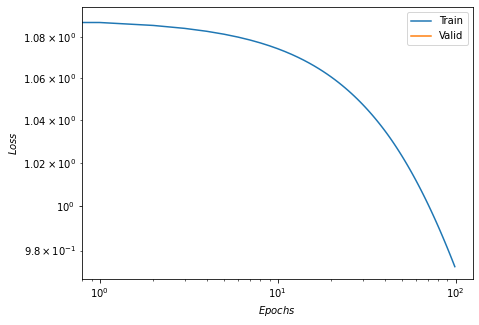

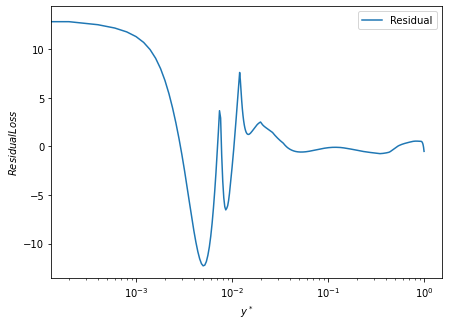

Final epoch loss (from residual):  0.9728371453606823
Final epoch loss (from train loss):  0.9728371453606824


In [29]:
'''Plot Training and Validation Loss''' 
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(train_loss, label='Train')
ax.plot(valid_loss, label='Valid')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$Epochs$')
ax.set_ylabel(r'$Loss$')
ax.legend(loc='best')
plt.show()

residualloss = solver.residuals
residualloss = residualloss.detach().cpu().numpy()

'''Plot Residual Loss''' 
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(y_norm_nn,residualloss, label='Residual')
ax.set_xscale('log')
ax.set_xlabel(r'$y^*$')
ax.set_ylabel(r'$Residual Loss$')
ax.legend(loc='best')
plt.show()

# Check if loss matches residual
print('Final epoch loss (from residual): ', (residualloss**2).mean())
print('Final epoch loss (from train loss): ', train_loss[-1])

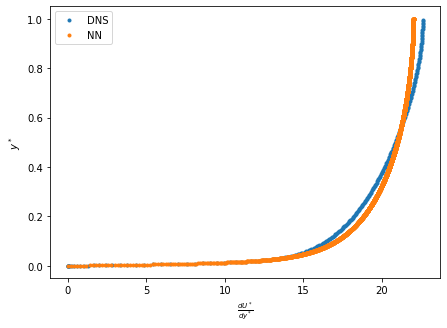

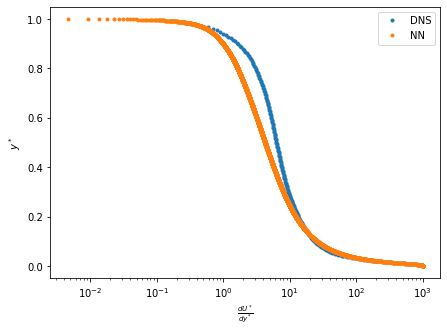

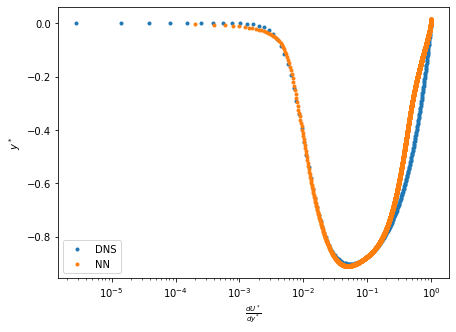

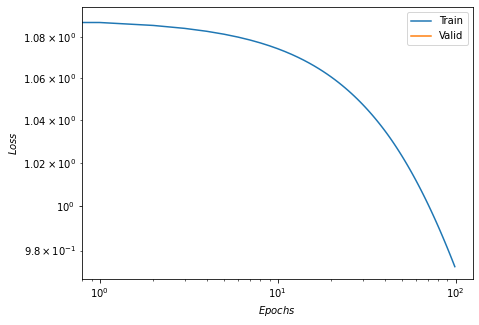

In [30]:
import matplotlib.pyplot as plt
'''Plot Velocity Profile''' 
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(u_norm_DNS, y_norm_DNS, '.', label='DNS')
ax.plot(u_norm_nn, y_norm_nn, '.', label='NN')
ax.set_xlabel(r'$\frac{dU^*}{dy^*}$')
ax.set_ylabel(r'$y^*$')
ax.legend(loc='best')
plt.show()
 
'''Plot Velocity Gradient''' 
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(du_dy_norm_DNS, y_norm_DNS, '.', label='DNS')
ax.plot(du_dy_norm_nn, y_norm_nn, '.', label='NN')
ax.set_xlabel(r'$\frac{dU^*}{dy^*}$')
ax.set_ylabel(r'$y^*$')
ax.set_xscale('log')
ax.legend(loc='best')
plt.show()
 
'''Plot Anisotropic''' 
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(y_norm_DNS,a_uv_norm_DNS, '.', label='DNS')
ax.plot( y_norm_nn,a_uv_norm_nn, '.', label='NN')
ax.set_xlabel(r'$\frac{dU^*}{dy^*}$')
ax.set_ylabel(r'$y^*$')
ax.legend(loc='best')
ax.set_xscale('log')
plt.show()
 
'''Plot Training and Validation Loss''' 
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(train_loss, label='Train')
ax.plot(valid_loss, label='Valid')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$Epochs$')
ax.set_ylabel(r'$Loss$')
ax.legend(loc='best')
plt.show()

In [ ]:
os.chdir(r'/content/RANS_docs/results')

'''Neural Network Data'''
# Domain Data
pd.DataFrame(y_norm_nn).to_csv('y_norm_nn_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
 
# Neural Network Data
pd.DataFrame(u_norm_nn).to_csv('u_norm_nn_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
pd.DataFrame(du_dy_norm_nn).to_csv('du_dy_norm_nn_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
pd.DataFrame(d2u_dy2_norm_nn).to_csv('d2u_dy2_norm_nn_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
pd.DataFrame(da_uv_dy_norm_nn).to_csv('da_uv_dy_norm_nn_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
pd.DataFrame(a_uv_norm_nn).to_csv('a_uv_norm_nn_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
 
# Training Loss, Validation Loss and Residual Loss
pd.DataFrame(train_loss).to_csv('train_loss_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
pd.DataFrame(residualloss).to_csv('residual_loss_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
 
# Terms of ODE
pd.DataFrame(first_order_term).to_csv('first_order_term_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
pd.DataFrame(second_order_term).to_csv('second_order_term_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
pd.DataFrame(pressure_term).to_csv('pressure_term_Re_tau_{0}_{1}_{2}_{3}_{4}.csv'.format(Retau,model,distribution,points_trainer,epochs))
 
'''Save model'''
torch.save(solver.nets[0], 'model_{0}_{1}_{2}.pt'.format(Retau,model,epochs))

# **Appendix A:** Solving RANS with Prandtl and Van Driest closure models numerically
Ideally, we would check the numerical solvers with Rui's neural network, to address this, but they too struggle to solve the RANS equation with Rui's model. They can do it for small Reynolds numbers, but for larger Reynolds such as 500, the number of points required to achieve a stable solutions is above the computer power.

In [36]:
''' Solving ODE numerically'''
# Parameters
Retau_bvp = 2000
points_bvp = 10000
distrib_bvp = 'logspace' 
tol_bvp = 1e-14

# Solve ODE numerically
[y_norm_bvp_Prandtl, u_norm_bvp_Prandtl,du_dy_norm_bvp_Prandtl] = solve_ODE('Prandtl',Retau_bvp,points_bvp,tol_bvp,A_plus,k,distrib_bvp)
[y_norm_bvp_vanDriest, u_norm_bvp_vanDriest,du_dy_norm_bvp_vanDriest] = solve_ODE('vanDriest',Retau_bvp,points_bvp,tol_bvp,A_plus,k,distrib_bvp)

# Get anisotropic Reynolds stress tensor
a_uv_Prandtl_bvp = a_uv_from_Prandtl(du_dy_norm_bvp_Prandtl,y_norm_bvp_Prandtl,Retau,'a_uv','torch')
a_uv_vanDriest_bvp = a_uv_from_vanDriest(du_dy_norm_bvp_vanDriest,y_norm_bvp_vanDriest,Retau,'a_uv','torch')